In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
path = '/content/drive/My Drive/money_lion/'
%cd '/content/drive/My Drive/money_lion/'

Mounted at /content/drive/
/content/drive/My Drive/money_lion


# Introduction:

The assessment's goal is to predict the loan risk or quality (loan repayment) on a given applicant.  

Using Machine Learning approach may be better approach as it provides a sharp edge to companies by performing credit risk assessment based on past data in anticipating risks due to uncertainities.

But it's important to have a clear understanding of our data beforehand and our specific problem domain before applying these techniques. This can help ensure that we choose the optimal solution and avoid potential pitfalls.

To predict the loan repayment, we must undestand how the loans are approved in the first place. 

Loan approval process follows such stages:
*   After the loan application is recieved,  risk assessment is done to approve the loan. 
*   After the loan is approved, it gets funded.

### **1. Problem Definition:**

Main Risk : 
The main risk of default on funded loans is that the borrower may be unable or unwilling to repay the loan.
 
We should able to mitigate the risk by configuring the defaulting risk out of funded loans.

In our data the defaulting risk is referred as loanStatus in the loan csv file.


In [ ]:
# load libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [ ]:
loan = pd.read_csv('data/loan.csv', parse_dates=['applicationDate','originatedDate'])

### The loan statues that are funded

In [ ]:
# consider only funded loans
Funded_loan = loan[loan['isFunded'].eq(1)]
Funded_loan['loanStatus'].value_counts(normalize=True)

Paid Off Loan                  0.293135
External Collection            0.290750
New Loan                       0.208096
Internal Collection            0.142733
Returned Item                  0.030322
Settlement Paid Off            0.018162
Settled Bankruptcy             0.008337
Pending Paid Off               0.004335
Charged Off Paid Off           0.004079
Charged Off                    0.000026
Settlement Pending Paid Off    0.000026
Name: loanStatus, dtype: float64

In [ ]:
# Total of 19 features of funded loans
Funded_loan.shape

(38982, 19)


# Create a target variable of loan-default

I am going to use loanStatus from funded load only as the target variable. But, we can't use it as is. 

From above we can seen from the funded load features but we only use features that tells either the funded load is being pain or defaulted.

We will categorize the target variable into two classes:

*   Class 0: consists of levels which signifiy that loan was paid
*   Class 1: consists of levels which signifiy that loan was defaulted

For Class 0, we will consider the following features:

*   Paid Off Loan
*   Settlement Paid Off

For Class 1, we will consider the following features:

*   Settled Bankruptcy
*   Charged Off: means the borrower has become delinquent in paying back.


It makes this problem a binary classification problem.


In [ ]:
#Save labels
labels = {1: ['Settled Bankruptcy','Charged Off'], 
          0:['Paid Off Loan','Settlement Paid Off']}

# Map labels
def map_label(data):
    for column,item in labels.items():
        if data in item:
            return column




Funded_loan['target'] = Funded_loan['loanStatus'].map(map_label)
trainData = Funded_loan[Funded_loan['target'].notna()].reset_index(drop=True)
trainData['target'] = trainData['target'].astype(int)
trainData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12461 entries, 0 to 12460
Data columns (total 20 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   loanId                            12461 non-null  object        
 1   anon_ssn                          12461 non-null  object        
 2   payFrequency                      12461 non-null  object        
 3   apr                               12461 non-null  float64       
 4   applicationDate                   12461 non-null  datetime64[ns]
 5   originated                        12461 non-null  bool          
 6   originatedDate                    12461 non-null  datetime64[ns]
 7   nPaidOff                          12454 non-null  float64       
 8   approved                          12461 non-null  bool          
 9   isFunded                          12461 non-null  int64         
 10  loanStatus                        12461 non-nu

<ipython-input-6-714309ba2fcb>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Funded_loan['target'] = Funded_loan['loanStatus'].map(map_label)


From below class '0' holds the majority of the whole dataset as it covers almost 97% of the data while leaving only another 3% for class '1'.

Based on that, The dataset is imblanced since most of the data is under Class 0.

In [ ]:
# get percentage count of new label variable
trainData['target'].value_counts(normalize=True)

0    0.973838
1    0.026162
Name: target, dtype: float64

<ipython-input-8-c5ddd563bd9d>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(trainData.loc[trainData['target'].notna(), 'target'])


<Axes: xlabel='target', ylabel='Density'>

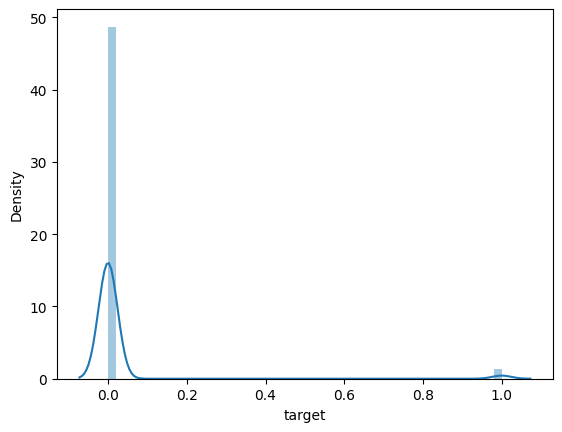

In [ ]:
sns.distplot(trainData.loc[trainData['target'].notna(), 'target'])

### Data Exploration

As being explained in introduction, Data Exploration is done as it is important to to gain an understanding of the data we have. 

In [ ]:
#list statistics of all features except loanId, clarityFraudId and anon_ssn
vars = ['loanId','clarityFraudId','anon_ssn']
for x in trainData.columns.difference(vars):
    print(x)
    print('-'*100)
    if trainData[x].dtype != 'object':
        print(trainData.groupby('target')[x].describe(percentiles=[.25,.5,.75,.95,.99]))
        print('*'*100)
    else:
        print(trainData.groupby('target')[x].value_counts(normalize=True, ascending=False, sort=True).unstack())


applicationDate
----------------------------------------------------------------------------------------------------
        count unique                         top freq  \
target                                                  
0       12135  12134  2015-02-20 17:16:24.718000    2   
1         326    326  2016-08-30 07:24:47.381000    1   

                             first                        last  
target                                                          
0       2014-12-03 00:31:22.306000  2017-03-18 23:34:27.369000  
1       2015-02-13 18:35:34.286000  2017-03-17 20:49:59.334000  
****************************************************************************************************
approved
----------------------------------------------------------------------------------------------------
        count unique   top   freq
target                           
0       12135      1  True  12135
1         326      1  True    326
***********************************************

<ipython-input-9-afef714f8891>:7: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(trainData.groupby('target')[x].describe(percentiles=[.25,.5,.75,.95,.99]))
<ipython-input-9-afef714f8891>:7: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(trainData.groupby('target')[x].describe(percentiles=[.25,.5,.75,.95,.99]))


****************************************************************************************************
originallyScheduledPaymentAmount
----------------------------------------------------------------------------------------------------
          count         mean          std     min      25%       50%      75%  \
target                                                                          
0       12135.0  1660.295432  1200.762347  188.41  949.455  1303.620  1942.56   
1         326.0  1713.532853  1278.321699  481.95  995.055  1327.195  1974.01   

              95%        99%       max  
target                                  
0       3624.3900  6814.2056  12550.08  
1       3995.0125  6901.1975   9380.70  
****************************************************************************************************
originated
----------------------------------------------------------------------------------------------------
        count unique   top   freq
target                       

<ipython-input-9-afef714f8891>:7: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(trainData.groupby('target')[x].describe(percentiles=[.25,.5,.75,.95,.99]))
<ipython-input-9-afef714f8891>:7: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(trainData.groupby('target')[x].describe(percentiles=[.25,.5,.75,.95,.99]))




Following are some quick insights we can generate from stats above:


1.  From "fpStatus", The percentage of defaulted loans that were unsuccessful for the first payment is 14%, whereas for paid loans, it is only 2%. This shows there is a higher likelihood of default for loans that were unsuccessful on the first payment. 

2.  From "byMandatory" 46% of defaulted loans shows that it had bank verification, which means that this may be a factor that contributes to loan default. In other words, loans that underwent bank verification before approval have a higher likelihood of default. 

3.  The "leadCost" of defaulted loan has higher mean than the "leadCost" of paid loan as the mean of "leadCost" for defaulted loan is 14.67 while for paid loan is 12.04. Suprisingly, this means the amount of money or resources required to generate a lead for a loan for defaulted loan is higher than paid loan.

4. The data shows that the mean number of paid off loans for defaulted clients is 0.32, while the mean number of paid off loans for non-defaulted loans is 0.59 from the "nPaidOff".  This suggests that :

      *   A client's track record of paying off loans in the past may be a factor that impacts their likelihood of defaulting on future loans. 
      *   Clients who have a higher number of paid off loans in the past may be seen as less risky borrowers by lenders, while clients who have a lower number of paid off loans may be seen as more risky and therefore more likely to default on future loans.











# Use information from clarityfraud file

In [ ]:
clarityFraud = pd.read_csv('data/clarity_underwriting_variables.csv')

trainData = trainData.merge(clarityFraud[['underwritingid','clearfraudscore']], 
                    left_on='clarityFraudId', 
                    right_on='underwritingid', 
                    how='left')

trainData.info()

<ipython-input-10-504d74061671>:1: DtypeWarning: Columns (9,11,12,13,14,15,16,17,18,19,20,21,22,23,25,26,27,28,29,31,32,33,36,37) have mixed types. Specify dtype option on import or set low_memory=False.
  clarityFraud = pd.read_csv('data/clarity_underwriting_variables.csv')


<class 'pandas.core.frame.DataFrame'>
Int64Index: 12461 entries, 0 to 12460
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   loanId                            12461 non-null  object        
 1   anon_ssn                          12461 non-null  object        
 2   payFrequency                      12461 non-null  object        
 3   apr                               12461 non-null  float64       
 4   applicationDate                   12461 non-null  datetime64[ns]
 5   originated                        12461 non-null  bool          
 6   originatedDate                    12461 non-null  datetime64[ns]
 7   nPaidOff                          12454 non-null  float64       
 8   approved                          12461 non-null  bool          
 9   isFunded                          12461 non-null  int64         
 10  loanStatus                        12461 non-nu

<ipython-input-11-5a0f8d211787>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(trainData.loc[trainData['clearfraudscore'].notna(), 'clearfraudscore'])


<Axes: xlabel='clearfraudscore', ylabel='Density'>

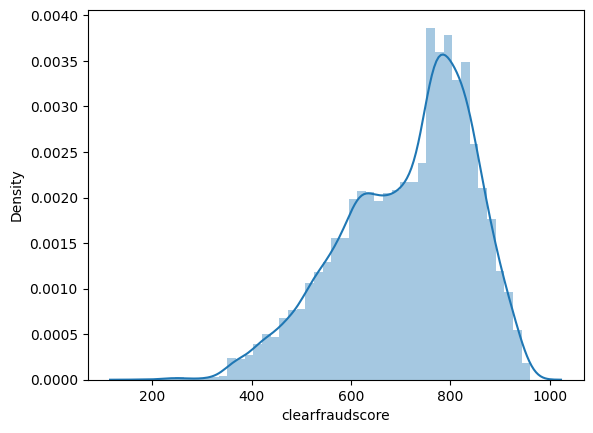

In [ ]:
sns.distplot(trainData.loc[trainData['clearfraudscore'].notna(), 'clearfraudscore'])

<Axes: xlabel='target', ylabel='clearfraudscore'>

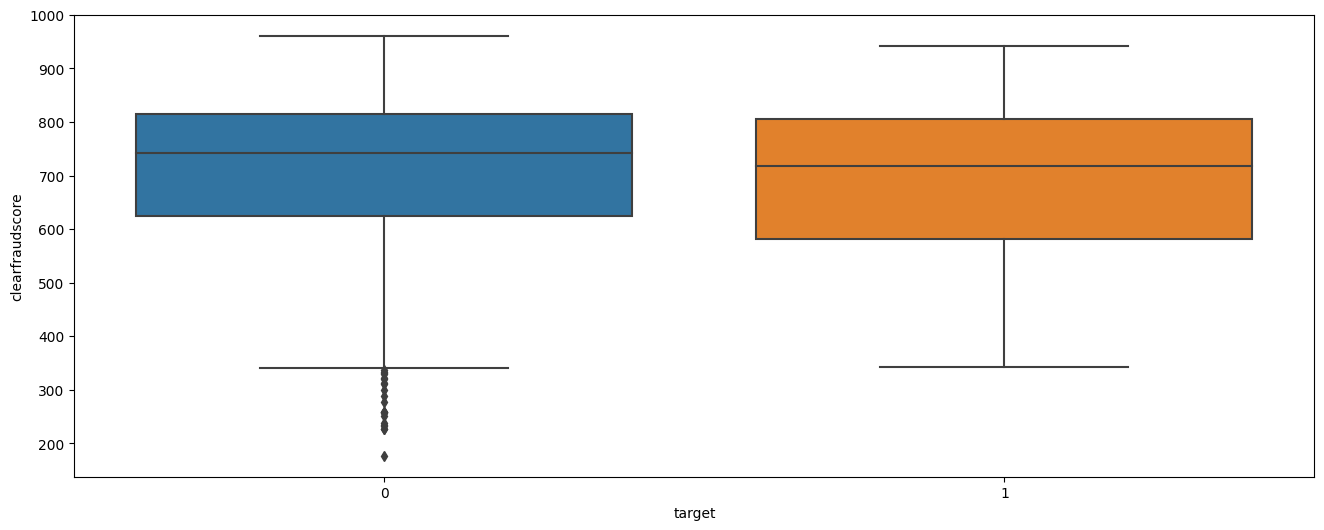

In [ ]:
plt.figure(figsize=(16, 6))
sns.boxplot(x = 'target',
            y="clearfraudscore",
            data=trainData.loc[trainData['clearfraudscore'].notna()])



*   The variable "clearfraudscore" is not normally distributed, but rather has a left-skewed distribution. This means that the majority of the scores are located on the right-hand side of the distribution, and there are few scores located on the left-hand side.
*   Defaulted-loans have higher minimum value for fraud score, starting around 350 as compared to non-defaulted loans where lower bound of fraud score is below 200. 
> This indicates that : 

    * The minimum value of the fraud score is higher for defaulted loans than for non-defaulted loans. This suggests that there may be a relationship between the fraud score and loan default, with higher fraud scores being associated with a higher risk of default.

    * The fact that the lower bound of the fraud score is below 200 for non-defaulted loans suggests that these loans are generally associated with lower risk of default, as compared to defaulted loans.





<Axes: xlabel='nPaidOff', ylabel='clearfraudscore'>

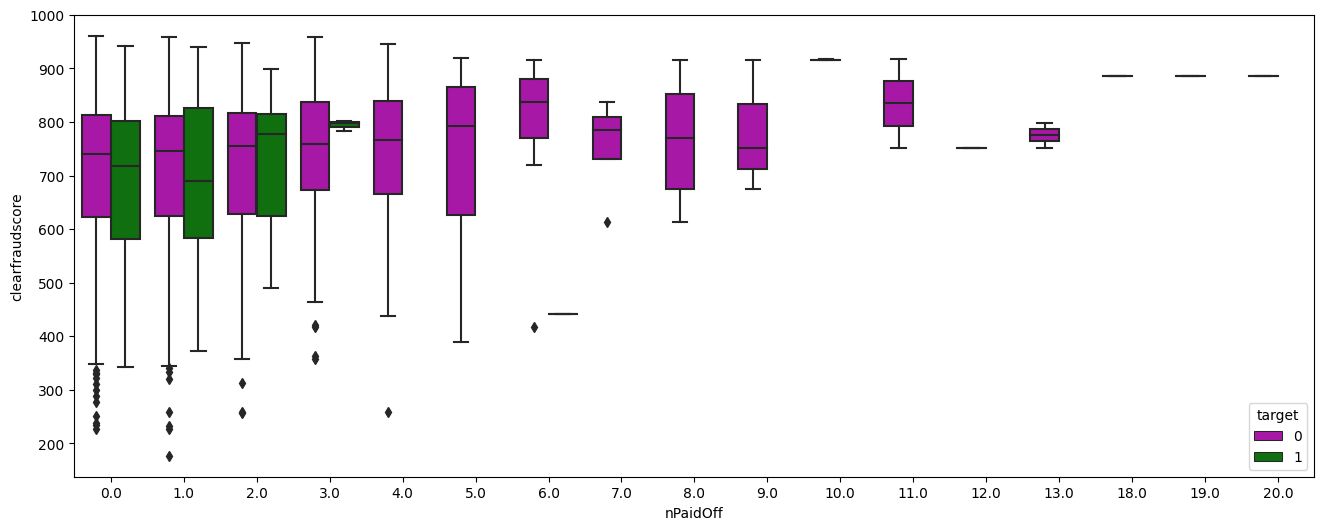

In [ ]:
plt.figure(figsize=(16, 6))
sns.boxplot(x="nPaidOff", y="clearfraudscore",
            hue="target", palette=["m", "g"],
            data=trainData[trainData['clearfraudscore'].notna()])

Based on the information provided, we can conclude that:


*   The box plot suggests that defaulted loans tend to have fewer loans paid off, with a maximum of 3 loans paid off because the nPaidOff of defaulted loan are less than 4 times but paid loan has the nPaidOff up to 13 times.
 
    * This may indicate that borrowers who have a history of paying off fewer loans may be at higher risk of defaulting on their loans.

*   On the other hand, borrowers who have paid off more loans in the past (more than 6) have a higher median value for clearfraudscore. However, without further information about this variable, it is difficult to draw any conclusions about this behavior.

Overall, the box plot provides some insights into the relationship between the number of loans paid off and the clearfraudscore, and how this varies between defaulted and non-defaulted loans. However, further analysis and additional information would be needed to determine the strength and nature of these relationships.

# Feature Engineering

After exploring the data, few new variables need to create to transform raw data into features that better represent the underlying problem to the predictive models.

First we make new variable feature by counting the number of loan using SSN

In [ ]:
# Count Loan by using SSN
trainData['countLoan'] = trainData['anon_ssn'].map(trainData.groupby('anon_ssn')['loanId'].count()).astype(int)
trainData.head()

,loanId,anon_ssn,payFrequency,apr,applicationDate,originated,originatedDate,nPaidOff,approved,isFunded,...,state,leadType,leadCost,fpStatus,clarityFraudId,hasCF,target,underwritingid,clearfraudscore,countLoan
0,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19 22:07:36.778,True,2016-01-20 15:49:18.846,0.0,True,1,...,CA,prescreen,0,Checked,569eb3a3e4b096699f685d64,1,0,569eb3a3e4b096699f685d64,879.0,1
1,LL-I-16519347,bc9fa73468acf18cb968a3a6a3c4697c,S,490.0,2017-01-31 17:48:17.381,True,2017-01-31 18:00:14.520,2.0,True,1,...,MO,organic,0,Checked,58450a15e4b0bb9d6d7344c7,1,0,58450a15e4b0bb9d6d7344c7,835.0,4
2,LL-I-11506719,10cefd11d41612b032fd9cd2debe32dc,B,590.0,2016-08-27 09:08:05.442,True,2016-08-29 15:05:04.014,0.0,True,1,...,CA,bvMandatory,10,Checked,578f9346e4b0810ad5e7b72e,1,0,578f9346e4b0810ad5e7b72e,624.0,1
3,LL-I-09279047,1d249e27292d25e4d3b4bc142a2a4aea,W,404.1,2016-05-25 03:05:18.849,True,2016-05-25 15:11:36.260,3.0,True,1,...,WI,organic,0,Checked,56621584e4b0100e84141586,1,0,56621584e4b0100e84141586,770.0,3
4,LL-I-01316580,2a10b2e04c5eec9a47a8cf5b9b81a2b8,W,590.0,2015-05-26 17:02:27.312,True,2015-05-26 18:45:48.024,0.0,True,1,...,MO,bvMandatory,6,Rejected,NaN,0,0,NaN,NaN,1


<Axes: xlabel='target', ylabel='countLoan'>

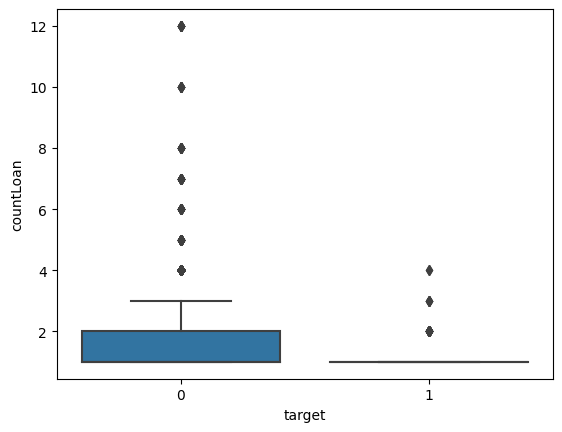

In [ ]:
sns.boxplot(x = 'target',
            y="countLoan",
            data=trainData)

The box plot above shows that the countLoan between two classes have very big difference. Class 0 have higher countLoan compared to Class 1. The defaulted loans motsly come from new customers.

In [ ]:
# count past paid loan by client
trainData['countPaidOff'] = trainData['anon_ssn'].map(Funded_loan.groupby('anon_ssn')['nPaidOff'].sum()).astype(int)
trainData.head()

,loanId,anon_ssn,payFrequency,apr,applicationDate,originated,originatedDate,nPaidOff,approved,isFunded,...,leadType,leadCost,fpStatus,clarityFraudId,hasCF,target,underwritingid,clearfraudscore,countLoan,countPaidOff
0,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19 22:07:36.778,True,2016-01-20 15:49:18.846,0.0,True,1,...,prescreen,0,Checked,569eb3a3e4b096699f685d64,1,0,569eb3a3e4b096699f685d64,879.0,1,0
1,LL-I-16519347,bc9fa73468acf18cb968a3a6a3c4697c,S,490.0,2017-01-31 17:48:17.381,True,2017-01-31 18:00:14.520,2.0,True,1,...,organic,0,Checked,58450a15e4b0bb9d6d7344c7,1,0,58450a15e4b0bb9d6d7344c7,835.0,4,6
2,LL-I-11506719,10cefd11d41612b032fd9cd2debe32dc,B,590.0,2016-08-27 09:08:05.442,True,2016-08-29 15:05:04.014,0.0,True,1,...,bvMandatory,10,Checked,578f9346e4b0810ad5e7b72e,1,0,578f9346e4b0810ad5e7b72e,624.0,1,1
3,LL-I-09279047,1d249e27292d25e4d3b4bc142a2a4aea,W,404.1,2016-05-25 03:05:18.849,True,2016-05-25 15:11:36.260,3.0,True,1,...,organic,0,Checked,56621584e4b0100e84141586,1,0,56621584e4b0100e84141586,770.0,3,14
4,LL-I-01316580,2a10b2e04c5eec9a47a8cf5b9b81a2b8,W,590.0,2015-05-26 17:02:27.312,True,2015-05-26 18:45:48.024,0.0,True,1,...,bvMandatory,6,Rejected,NaN,0,0,NaN,NaN,1,1


<Axes: xlabel='target', ylabel='countPaidOff'>

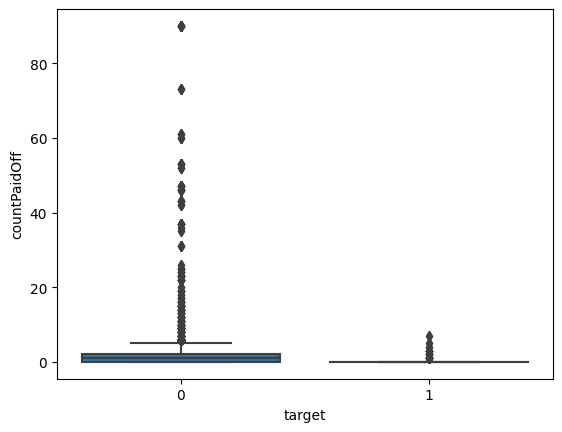

In [ ]:
sns.boxplot(x = 'target',
            y="countPaidOff",
            data=trainData)



Class 0 has higher countPaidOff than class 1 which means paid off loans are mostly come fron existing customers.

In [ ]:
# day taken for loan to be approved
trainData['day_taken'] = (trainData['originatedDate'] - trainData['applicationDate']).astype('timedelta64[D]').astype(int)
trainData['day_taken']
trainData.head()

,loanId,anon_ssn,payFrequency,apr,applicationDate,originated,originatedDate,nPaidOff,approved,isFunded,...,leadCost,fpStatus,clarityFraudId,hasCF,target,underwritingid,clearfraudscore,countLoan,countPaidOff,day_taken
0,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19 22:07:36.778,True,2016-01-20 15:49:18.846,0.0,True,1,...,0,Checked,569eb3a3e4b096699f685d64,1,0,569eb3a3e4b096699f685d64,879.0,1,0,0
1,LL-I-16519347,bc9fa73468acf18cb968a3a6a3c4697c,S,490.0,2017-01-31 17:48:17.381,True,2017-01-31 18:00:14.520,2.0,True,1,...,0,Checked,58450a15e4b0bb9d6d7344c7,1,0,58450a15e4b0bb9d6d7344c7,835.0,4,6,0
2,LL-I-11506719,10cefd11d41612b032fd9cd2debe32dc,B,590.0,2016-08-27 09:08:05.442,True,2016-08-29 15:05:04.014,0.0,True,1,...,10,Checked,578f9346e4b0810ad5e7b72e,1,0,578f9346e4b0810ad5e7b72e,624.0,1,1,2
3,LL-I-09279047,1d249e27292d25e4d3b4bc142a2a4aea,W,404.1,2016-05-25 03:05:18.849,True,2016-05-25 15:11:36.260,3.0,True,1,...,0,Checked,56621584e4b0100e84141586,1,0,56621584e4b0100e84141586,770.0,3,14,0
4,LL-I-01316580,2a10b2e04c5eec9a47a8cf5b9b81a2b8,W,590.0,2015-05-26 17:02:27.312,True,2015-05-26 18:45:48.024,0.0,True,1,...,6,Rejected,NaN,0,0,NaN,NaN,1,1,0


<Axes: xlabel='target', ylabel='day_taken'>

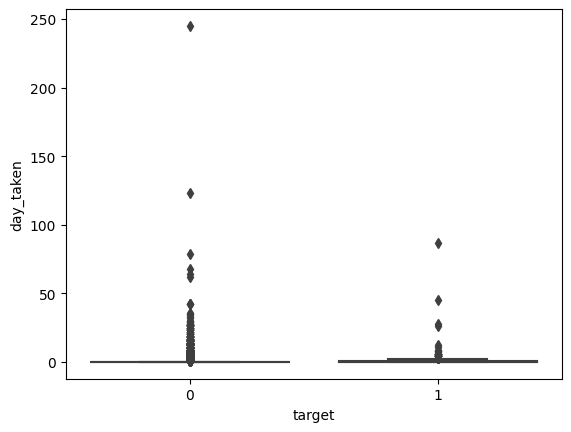

In [ ]:
sns.boxplot(x = 'target',
            y="day_taken",
            data=trainData)

Class 1 has lowers days_taken than class 0 which means class 1 tooke less time for loan to be approved. 

The possible reason may be the human approvers process some loans in hurry to meet their targets which results some loan application no throughly checked which cause default loans.


# Encode the categorical variables

Since model accept numeric variables, we need to encode string values into numeric.


In [ ]:
from sklearn.preprocessing import LabelEncoder

var = ['payFrequency','leadType','fpStatus','state']
for i in var:
    lbl = LabelEncoder()
    trainData[i + '_en'] = lbl.fit_transform(trainData[i])

In [ ]:
all_vars = ['clarityFraudId','underwritingid','originated','approved','isFunded','loanStatus','applicationDate','originatedDate','anon_ssn']

# variables not to be used
trainData = trainData.drop(var + all_vars, axis=1)

In [ ]:
trainData.head()

,loanId,apr,nPaidOff,loanAmount,originallyScheduledPaymentAmount,leadCost,hasCF,target,clearfraudscore,countLoan,countPaidOff,day_taken,payFrequency_en,leadType_en,fpStatus_en,state_en
0,LL-I-06644937,199.0,0.0,3000.0,6395.19,0,1,0,879.0,1,0,0,0,7,1,2
1,LL-I-16519347,490.0,2.0,1250.0,3313.78,0,1,0,835.0,4,6,0,3,6,1,19
2,LL-I-11506719,590.0,0.0,800.0,2432.08,10,1,0,624.0,1,1,2,0,0,1,2
3,LL-I-09279047,404.1,3.0,300.0,422.64,0,1,0,770.0,3,14,0,4,6,1,38
4,LL-I-01316580,590.0,0.0,300.0,896.87,6,0,0,NaN,1,1,0,4,0,2,19



# Use some info payment file

For a quick model, we are going to use only "paymentStatus" information for each "loanId". We are going to count the occurence of paymentStatus for each loanId.


In [ ]:
payment = pd.read_csv('data/payment.csv', parse_dates=['paymentDate'])

# Occurence of paymentStatus for each loanId
payment['val'] = 1

countPayment = (payment
 .pivot_table(index=['loanId'], columns=['paymentStatus'], values='val', aggfunc=sum, fill_value=0)
 .reset_index())

print(countPayment)



paymentStatus         loanId  Cancelled  Checked  Complete  None  Pending  \
0              LL-I-00000021          0       12         0     0        0   
1              LL-I-00000231          8        2         0     8        0   
2              LL-I-00000238          4        7         0     4        0   
3              LL-I-00000308         10        1         0    10        0   
4              LL-I-00000355         11        0         0    11        0   
...                      ...        ...      ...       ...   ...      ...   
39947          LP-I-00000127          0       12         0     0        0   
39948          LP-I-00000134          6        1         0     0        0   
39949          LP-I-00000139          0       12         0     0        0   
39950          LP-I-00000142         12        0         0     0        0   
39951          LP-I-00000145          0       12         0     0        0   

paymentStatus  Rejected  Rejected Awaiting Retry  Returned  Skipped  
0    

In [ ]:


trainData = (trainData.merge(countPayment, on='loanId', how='left')
         .drop(['loanId'], axis=1))
trainData.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 12461 entries, 0 to 12460
Data columns (total 24 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   apr                               12461 non-null  float64
 1   nPaidOff                          12454 non-null  float64
 2   loanAmount                        12461 non-null  float64
 3   originallyScheduledPaymentAmount  12461 non-null  float64
 4   leadCost                          12461 non-null  int64  
 5   hasCF                             12461 non-null  int64  
 6   target                            12461 non-null  int64  
 7   clearfraudscore                   9877 non-null   float64
 8   countLoan                         12461 non-null  int64  
 9   countPaidOff                      12461 non-null  int64  
 10  day_taken                         12461 non-null  int64  
 11  payFrequency_en                   12461 non-null  int64  
 12  lead


# Prediction Model



We are now ready to train a model. We are going to use a gradient boosting model because of the following reasons:


1.   We saw that the some variables are highly skewed. Tree based models are robust to skewness.
2.   The data has some null values, tree based models are robust to null 
values.
3. Tree based models are robust to outliers, we don't need to worry about them.
4. Tree based model can detect the non-linear behaviour in the data, thus providing better predictions than linear model
    

We are going to do a 70-30 split for train and validation data respectively.

Furthermore, AUC will be used to evaluate the model performance because:


1.   AUC is a better performance metric than accuracy
2.   AUC does not bias on size of test or evaluation data




In [ ]:
# import libraries
from sklearn.model_selection import train_test_split
import lightgbm as lgb

In [ ]:


label = trainData['target']
X_train, X_valid, y_train, y_valid = train_test_split(trainData, label, test_size=0.3,stratify = label)

X_train = X_train.drop(['target'], axis=1)
X_valid = X_valid.drop(['target'], axis=1)


#construct lgb dataset
train = lgb.Dataset(X_train.values,
                           label=y_train.values)
valid = lgb.Dataset(X_valid.values,
                       label=y_valid.values)


In [ ]:


## params values after parameter tuning
param = {
    'num_leaves': 18,
     'max_bin': 63,
     'min_data_in_leaf': 5,
     'learning_rate': 0.010614430970330217,
     'min_sum_hessian_in_leaf': 0.0093586657313989123,
     'feature_fraction': 0.056701788569420042,
     'min_gain_to_split': 0.29588543202055562,
     'max_depth': 3,
     'save_binary': True,
     'seed': 1337,
     'objective': 'binary',
     'boosting_type': 'gbdt',
     'verbose': 1,
     'metric': 'auc',
     'is_unbalance': True,
     'boost_from_average': False
}



In [ ]:
clf = lgb.train(param, 
                train,
                5000, 
                valid_sets = [train, valid], 
                verbose_eval=100,
                early_stopping_rounds=400)

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 228, number of negative: 8494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 509
[LightGBM] [Info] Number of data points in the train set: 8722, number of used features: 20
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 400 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga



Note: We see that the model returns 0.92 AUC score on validation set. We are using AUC here because:

Since it's an imbalanced problem, for our case, we need to be sure about false negatives. We can`t use a global metric such as accuracy since it would capture the overall performance of the model and not on a per class basis.

AUC will help us detect the false positive, because usually for companies commiting false negatives have high business cost.



# Feature Importance

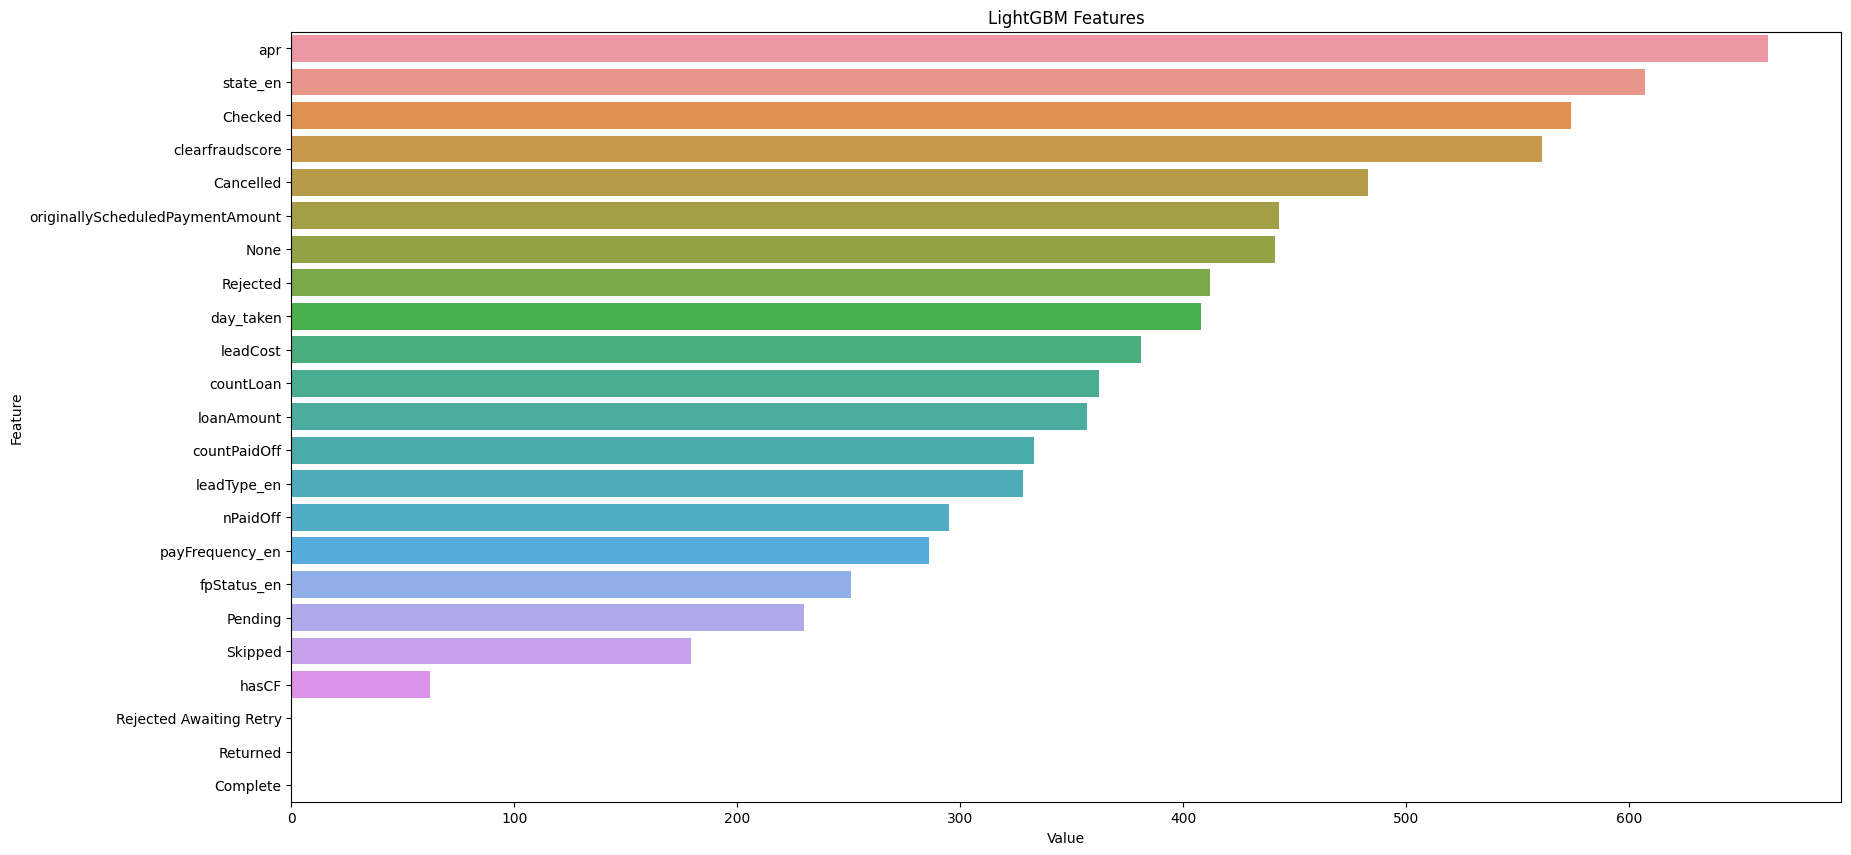

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importance(),X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.show()

In [ ]:
#remove features there are less important
unwant_feat = ['Rejected Awaiting Retry','hasCF','Returned','Complete']
trainData = trainData.drop(unwant_feat, axis=1)

In [ ]:
#Split the dataset again
label = trainData['target']
X_train, X_valid, y_train, y_valid = train_test_split(trainData, label, test_size=0.3,stratify = label)

X_train = X_train.drop(['target'], axis=1)
X_valid = X_valid.drop(['target'], axis=1)
train = lgb.Dataset(X_train.values,
                           label=y_train.values)
valid = lgb.Dataset(X_valid.values,
                       label=y_valid.values)

In [ ]:
clf = lgb.train(param, 
                train,
                5000, 
                valid_sets = [train, valid], 
                verbose_eval=100,
                early_stopping_rounds=400)

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 228, number of negative: 8494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008967 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 506
[LightGBM] [Info] Number of data points in the train set: 8722, number of used features: 19
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 400 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

After remove some features, the AUC of the model has increased to 0.92 


# Summary

In this report, we achieved 0.92 AUC score in determining whether a loan will be defaulted or not. We explored past loan performance and understood i.e. what kind of people are more likely to default. We also learned that the given problem is an imbalanced problem, hence we need to very careful in deciding model evaluation. We cannot use global metrics like accuracy which are mis-leading in this case.
